# Policy gradient variations

In the previous notebook we ended with the following equation for estimating the gradient of the expected return for a certain policy $\pi_\theta$:

\begin{equation*}
\tag{1}
\nabla_\theta J(\pi_\theta) = \underset{\tau \sim \pi_\theta}{\mathbb{E}}[\sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t | s_t) R(\tau)]
\end{equation*}

where $R(\tau)$, the return of an episode, is defined is:

$$
R(\tau) = \sum_{t=0}^T r_t
$$

When thinking about this equation intuitively, it basically *scales* the probability of an action $a_t$ given a certain state $s_t$ with the return of the episode they belong to. If that episode was a 'good' one, i.e. a high return, the term will increase, further 'reinforcing' that action. If the return is bad, it will not be reinforced as much. Over time, this will make actions that lead to a high return more likely than actions that lead to a lower return. 


However, this means that an action that occurred halfway through an episode, also incorporates rewards from timesteps that happened *before* that action. But how can an action be responsible for something that happened before that action was taken?

Instead, we want actions to be reinforced based on rewards that happened *after* that action.

### Reward-to-go

So, instead of using $R(\tau)$, we can come up with one simple alternative: using all rewards that happend *after* taking a certain action:
$$
\hat{R}(\tau, t) = \sum_{t'=t}^T r_{t'}
$$

This is often referred to as the *reward-to-go*. Now we can update equation $(1)$ as follows:

\begin{equation*}
\tag{2}
\nabla_\theta J(\pi_\theta) = \underset{\tau \sim \pi_\theta}{\mathbb{E}}[\sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t | s_t) \hat{R}(\tau, t)
\end{equation*}

The derivation for this is based on a proof that shows that the *expected gradient* for this term, for all timesteps prior to the current timestep, are 0, hence making it possible to emit them. The proof is in my opinion best explained [here](https://spinningup.openai.com/en/latest/spinningup/extra_pg_proof1.html).

Let's see how to implement this.

### Reused code
First, let's reuse most of the code for working with agents and environments. This is hidden because it is the same as the previous notebook.

In [11]:
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
import numpy as np
from typing import Literal

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
torch.manual_seed(13)

from IPython import display

In [2]:
env = TimeLimit(gym.make('CartPole-v1', render_mode="rgb_array"), max_episode_steps=300)

In [3]:
class DiscretePolicy(nn.Module):
    def __init__(self, observation_size, actions_size, layer_sizes=[32]):
        super().__init__()

        layer_sizes = [observation_size] + layer_sizes

        layers = []
        for layer_in, layer_out in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(layer_in, layer_out))
            layers.append(nn.ReLU())

        self.net = nn.Sequential(*layers)
        self.output = nn.Linear(layer_sizes[-1], actions_size)

    def forward(self, x):
        logits = self.output(self.net(x))
        return logits

    def get_action_distribution(self, observations):
        return Categorical(logits=self(torch.as_tensor(observations, dtype=torch.float32)))

In [39]:
def run_episode(env, policy, seed=None):
    """ Gathers experience for one episode and stores it in the buffer. """
    observations = []
    actions = []
    rewards = []
    episode_return = 0

    observation, _ = env.reset(seed=seed)

    done = False
    while not done:
        # During the collection of an episode, we do not need to store gradients.
        with torch.no_grad():
            action_distribution = policy.get_action_distribution(observation)

        action = action_distribution.sample().item()
        new_observation, reward, terminated, truncated, info = env.step(action)
        episode_return += reward

        # Store information about timestep t.
        observations.append(observation)
        actions.append(action)
        rewards.append(reward)

        if terminated or truncated:
            done = True

        observation = new_observation

    return observations, actions, rewards

### Implementing reward to go
Now, let's implement the 'memory' of the agent, i.e. the experience buffer. In the previous notebook we stored the 'returns' of the full episode, which is the same as for every timestep in the episode the sum of all the rewards in the episode.

In this implementation we will not calculate the 'returns', but we will calculate the 'reward-to-go' for every timestep in the episode. Remember that the equation for this is:
$$
\hat{R}(\tau, t) = \sum_{t'=t}^T r_{t'}
$$

And a simple way to implement this is to reverse the list of rewards, take the cumulative sum that list, and reverse it back.

Below we will implement an experience buffer that supports different types of 'weight calculations', where the weights do *not* refer to the weights of the policy neural network, but it refers to the factor with which the policy gradients are scaled (right now we have the options $R(\tau)$ and $\hat{R}(\tau, t)$).

In [38]:
class ExperienceBuffer:
    """ A class that stores experience. Can be used by storing episodes of data gathered by a specific policy
    and provides helper functions for working with this experience during training. """

    def __init__(self, weight_method: Literal["returns", "reward_to_go"] = "reward_to_go"):
        """
        :param weight_method: specifies the way for calculating the weights by which the gradients
                              need to be multiplied.
        """
        self.observations = []
        self.actions = []
        self.rewards = []
        self.weights = []

        self.weight_method = weight_method

    def store_episode(self, observations, actions, rewards):
        """ Stores all observations, actions and rewards for one episode. It also calculates the 'return' for this episode
        and adds it as a list for all timesteps in the episode. """

        assert len(observations) == len(actions) == len(rewards), "There should be an equal amount of observations, actions and rewards."

        self.observations.extend(observations)
        self.actions.extend(actions)
        self.rewards.extend(rewards)

        match self.weight_method:
            case "returns":
                episode_return = sum(rewards)
                self.weights += [episode_return] * len(observations)
            case "reward_to_go":
                self.weights += np.cumsum(rewards[::-1])[::-1].tolist()

    def get_as_tensors(self):
        """ Returns all experience so far as tensors. """
        return (
            torch.as_tensor(np.array(self.observations), dtype=torch.float32),
            torch.as_tensor(np.array(self.actions), dtype=torch.float32),
            torch.as_tensor(np.array(self.rewards), dtype=torch.float32),
            torch.as_tensor(np.array(self.weights), dtype=torch.float32),
        )

    def size(self):
        return len(self.observations)

    def clear(self):
        """ Clears the buffer, making it ready for a new episode. """

        self.observations = []
        self.actions = []
        self.rewards = []
        self.weights = []

The piece of code below is extremely similar to the training code in the previous notebook, with the following distinction: we can now have different types of scaling the gradient of the policy. Therefore this line:

```loss = -1 * (policy.get_action_distribution(observations).log_prob(actions) * returns).mean()```

Is changed in the following:

```loss = -1 * (policy.get_action_distribution(observations).log_prob(actions) * weights).mean()```

Where weights can be either the full return of the episode or the reward-to-go.


In [40]:
def train_policy(
    env,
    weight_method: Literal["returns", "reward_to_go"] = "returns",
    n_epochs=100,
    n_episodes_per_epoch=100,
    learning_rate=1e-2,
    verbose=False,
):
    """
    This function trains a policy for a given number of epochs, gathering a specified number of episodes
    every epoch in order to estimate the expected return for the policy.

    It returns a trained policy and the average return of all episodes for that epoch.
    """

    buffer = ExperienceBuffer(weight_method=weight_method)
    policy = DiscretePolicy(
        observation_size=env.observation_space.shape[0],
        actions_size=env.action_space.n,
        layer_sizes=[32],
    )
    optimizer = torch.optim.Adam(policy.parameters(), lr=learning_rate)

    returns_per_epoch = []
    
    for epoch in range(n_epochs):
        buffer.clear()
        returns = []
        for _ in range(n_episodes_per_epoch):
            observations, actions, rewards = run_episode(env, policy)
            buffer.store_episode(observations, actions, rewards)
            returns.append(sum(rewards))

        observations, actions, rewards, weights = buffer.get_as_tensors()
        loss = -1 * (policy.get_action_distribution(observations).log_prob(actions) * weights).mean()
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        average_return = np.mean(returns)
        returns_per_epoch.append(average_return)

        if verbose:
            print(f"Finished epoch {epoch}. Average return over 100 episodes: {average_return}")

    return (
        policy,
        {
            "returns": returns_per_epoch,
        },
    )

Now let's train a policy using 'returns' as weights and one using 'reward-to-go' as weights and compare the results.

In [52]:
results_returns = []
results_reward_to_go = []

for i in range(10):
    print(f"Running trial {i}")
    _, train_info_returns = train_policy(env, weight_method="returns", n_epochs=100, n_episodes_per_epoch=50, learning_rate=1e-2)
    results_returns.append(train_info_returns["returns"])

    _, train_info_rtg = train_policy(env, weight_method="reward_to_go", n_epochs=100, n_episodes_per_epoch=50, learning_rate=1e-2)
    results_reward_to_go.append(train_info_rtg["returns"])

Running trial 0
Running trial 1
Running trial 2
Running trial 3
Running trial 4
Running trial 5
Running trial 6
Running trial 7
Running trial 8
Running trial 9


In [53]:
def plot_line_collection(results: list[list[float]], ax=None, label=""):
    """ Plots a list of experiment results. """

    data = np.array(results)
    average_line = data.mean(axis=0)
    standard_deviations = data.std(axis=0)

    upper_bound = average_line + standard_deviations
    lower_bound = average_line - standard_deviations

    ax = sns.lineplot(average_line, ax=ax, label=label)
    ax.fill_between(np.arange(len(average_line)), lower_bound, upper_bound, alpha=.3)
    return ax

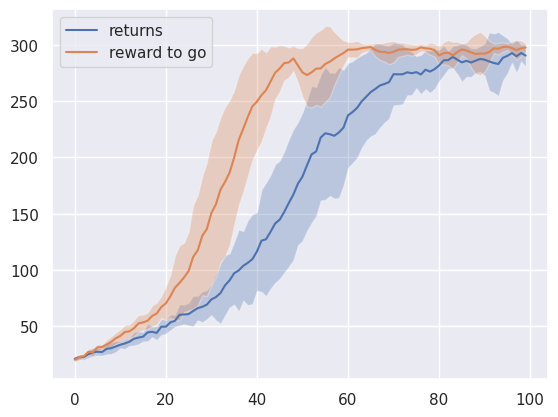

In [54]:
ax = plot_line_collection(results_returns, label="returns")
plot_line_collection(results_reward_to_go, ax=ax, label="reward to go")
ax.legend()
plt.show()